In [1]:
import pickle
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from centrex_tlf import states, hamiltonian, transitions, couplings, lindblad, utils
from centrex_tlf_julia_extension import lindblad_julia

c:\Users\ogras\anaconda3\envs\centrex-tlf\lib\site-packages\julia\juliainfo.py:93: UserWarning: julia warned:
The latest version of Julia in the `release` channel is 1.10.5+0.x64.w64.mingw32. You currently have `1.10.4+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.10.5+0.x64.w64.mingw32 and update the `release` channel to that version.
  warnings.warn("{} warned:\n{}".format(julia, stderr))


In [2]:
plt.rcParams.update({"font.size": 15})

In [3]:
path = Path.cwd()
fname = "R0 F1 detection.pkl"
data = {}

In [4]:
def get_diagonal_indices_flattened(size, states=None, mode="python"):
    if states is None:
        indices = [i + size * i for i in range(size)]
    else:
        indices = [i + size * i for i in states]
    if mode == "julia":
        return [i + 1 for i in indices]
    elif mode == "python":
        return indices

In [5]:
trans = [
    transitions.OpticalTransition(
        transitions.OpticalTransitionType.R, J_ground=0, F1=1 / 2, F=1
    ),
]

polarizations = [
    [couplings.polarization_Z, couplings.polarization_X],
]

transition_selectors = couplings.generate_transition_selectors(
    trans,
    polarizations,
)

In [6]:
v_to_Γ = utils.detuning.velocity_to_detuning(1)

odepars = lindblad_julia.odeParameters(
    Ω0="Ωl0 * phase_modulation(t, β, ωphase)",
    Ωl0=1 * hamiltonian.Γ,  # Rabi frequency of the laser [rad/s]
    δ0=f"vx*{v_to_Γ}",  # detuning of the laser [rad/s]
    # laser phase modulation
    ωphase=hamiltonian.Γ,  # laser phase modulation frequency [rad/s]
    β=0.0,  # laser phase modulation depth [rad]
    ω0=2 * np.pi * 1.56e6,  # polarization switching frequency [rad/s]
    φ0=0.0,  # polarization switching phase [rad]
    PZ0="resonant_switching(t, ω0, ϕ0)",
    PX0="1-PZ0",
    # molecules
    z0=0.0,  # molecule start z position [m]
    vz=184.0,  # longitudinal molecular velocity [m/s]
    vx=0.0,
)

In [7]:
obe_system = lindblad.setup_OBE_system_transitions(
    trans,
    transition_selectors,
    verbose=True,
    qn_compact=True,
    decay_channels=None,
    Jmax_X=3,
)

INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 1/5 -> Generating the reduced Hamiltonian
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 2/5 -> Generating the couplings corresponding to the transitions
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 3/5 -> Generating the symbolic Hamiltonian
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 4/5 -> Generating the collapse matrices
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 5/5 -> Transforming the Hamiltonian and collapse matrices into a symbolic system of equations


In [8]:
obe_system.H_symbolic

Matrix([
[                        δ0,                          0,                          0,                          0,                0, -0.353553390506304*PX0*Ω0,                0.5*PZ0*Ω0,  0.353553390680357*PX0*Ω0],
[                         0,      δ0 - 83566.1617128386,                          0,                          0,                0, -0.521923602619182*PZ0*Ω0, -0.369055718632925*PX0*Ω0,                         0],
[                         0,                          0,      δ0 - 83566.3655475656,                          0,                0, -0.369055718684297*PX0*Ω0,                         0, -0.369055718603592*PX0*Ω0],
[                         0,                          0,                          0,      δ0 - 83566.5693822375,                0,                         0, -0.369055718632926*PX0*Ω0,  0.521923602505049*PZ0*Ω0],
[                         0,                          0,                          0,                          0, 256817005329.751,         

In [9]:
[qn.largest for qn in obe_system.QN]

[|X, J = 0, F₁ = 1/2, F = 0, mF = 0, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>,
 |X, J = 0, F₁ = 1/2, F = 1, mF = -1, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>,
 |X, J = 0, F₁ = 1/2, F = 1, mF = 0, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>,
 |X, J = 0, F₁ = 1/2, F = 1, mF = 1, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>,
 |X, J = 2, F₁ = None, F = None, mF = None, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>,
 |B, J = 1, F₁ = 1/2, F = 1, mF = -1, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 1>,
 |B, J = 1, F₁ = 1/2, F = 1, mF = 0, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 1>,
 |B, J = 1, F₁ = 1/2, F = 1, mF = 1, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 1>]

In [12]:
obe_system = lindblad_julia.setup_OBE_system_julia(
    obe_system, transition_selectors, odepars
)

In [13]:
couplings.generate_br_dataframe(obe_system.ground, obe_system.excited, group_ground="J")

,"|B, J = 1, F₁ = 1/2, F = 1>"
states,
"|X, J = 0>",0.666454
"|X, J = 2>",0.333546


In [14]:
couplings.generate_br_dataframe(
    obe_system.ground, obe_system.excited, group_ground="mF"
)

,"|B, J = 1, F₁ = 1/2, F = 1>"
states,
"|X, J = 0, F₁ = 1/2, F = 0>",0.209627
"|X, J = 0, F₁ = 1/2, F = 1>",0.456827
"|X, J = 2, F₁ = 3/2, F = 1>",0.049956
"|X, J = 2, F₁ = 3/2, F = 2>",0.283386
"|X, J = 2, F₁ = 5/2, F = 2>",0.000203


## Population in F=1 only

In [18]:
ρ = utils.population.generate_uniform_population_states(
    states.QuantumSelector(J=0, F=1, electronic=states.ElectronicState.X), obe_system.QN
)

rabi_rates = np.linspace(0, 1, 52)[1:] * hamiltonian.Γ
polarization_freqs = np.linspace(0, 2, 52)[1:] * hamiltonian.Γ

In [31]:
# only save excited state populations

state_selector = states.QuantumSelector(electronic=states.ElectronicState.B)
indices = state_selector.get_indices(obe_system.QN)
indices = [i.item() for i in indices]

save_idxs = get_diagonal_indices_flattened(len(obe_system.QN), indices, mode="julia")

odepars.ωphase = 0.0
odepars.β = 0.0
odepars.ω0 = 0.0

In [32]:
ensemble_config = lindblad_julia.OBEEnsembleProblemConfig(
    method="Tsit5()", save_idxs=save_idxs, saveat=1e-6, save_everystep=True
)

problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 5e-3 / odepars.vz))

scan_values = [rabi_rates, polarization_freqs]
parameters = ["Ωl0", "ω0"]

output_func = lindblad_julia.setup_state_integral_calculation_state_idxs(nphotons=True)


ensemble_problem = lindblad_julia.OBEEnsembleProblem(
    problem=problem,
    parameters=parameters,
    scan_values=scan_values,
    output_func=output_func,
)

lindblad_julia.setup_problem_parameter_scan(
    ensemble_problem,
)

lindblad_julia.solve_problem_parameter_scan(ensemble_problem, ensemble_config)

In [33]:
results_F1 = lindblad_julia.get_results_parameter_scan(scan=ensemble_problem)

In [34]:
data["results_F1"] = results_F1
with open(path / fname, "wb") as filehandle:
    pickle.dump(data, filehandle)

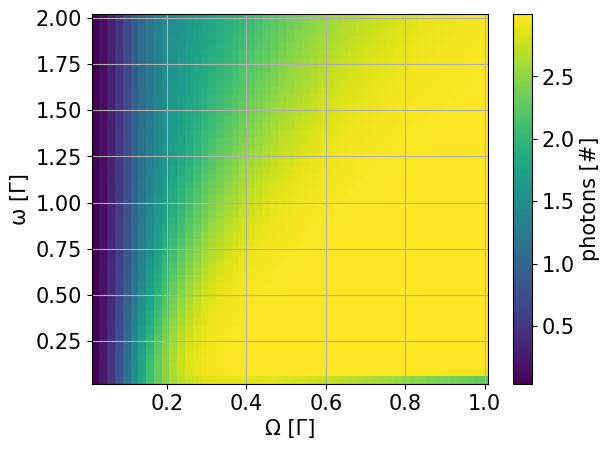

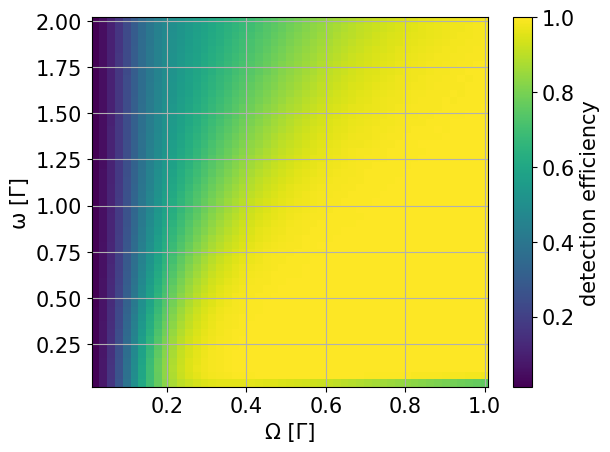

In [35]:
fig, ax = plt.subplots()
pcolor = ax.pcolormesh(
    *(np.asarray(results_F1.scan_values) / hamiltonian.Γ), results_F1.results
)

cbar = fig.colorbar(pcolor)
cbar.ax.set_ylabel("photons [#]")

ax.set_xlabel("Ω [Γ]")
ax.set_ylabel("ω [Γ]")
ax.grid(True)

fig, ax = plt.subplots()
pcolor = ax.pcolormesh(
    *(np.asarray(results_F1.scan_values) / hamiltonian.Γ),
    results_F1.results / results_F1.results.max(),
)

cbar = fig.colorbar(pcolor)
cbar.ax.set_ylabel("detection efficiency")

ax.set_xlabel("Ω [Γ]")
ax.set_ylabel("ω [Γ]")
ax.grid(True)

## Population in F=0 only

In [36]:
ρ = utils.population.generate_uniform_population_states(
    states.QuantumSelector(J=0, F=0, electronic=states.ElectronicState.X), obe_system.QN
)

In [37]:
ensemble_config = lindblad_julia.OBEEnsembleProblemConfig(
    method="Tsit5()", save_idxs=save_idxs, saveat=1e-6, save_everystep=True
)

problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 5e-3 / odepars.vz))

scan_values = [rabi_rates, polarization_freqs]
parameters = ["Ωl0", "ω0"]

output_func = lindblad_julia.setup_state_integral_calculation_state_idxs(nphotons=True)


ensemble_problem = lindblad_julia.OBEEnsembleProblem(
    problem=problem,
    parameters=parameters,
    scan_values=scan_values,
    output_func=output_func,
)

lindblad_julia.setup_problem_parameter_scan(
    ensemble_problem,
)

lindblad_julia.solve_problem_parameter_scan(ensemble_problem, ensemble_config)

In [38]:
results_F0 = lindblad_julia.get_results_parameter_scan(scan=ensemble_problem)

In [39]:
data["results_F0"] = results_F0
with open(path / fname, "wb") as filehandle:
    pickle.dump(data, filehandle)

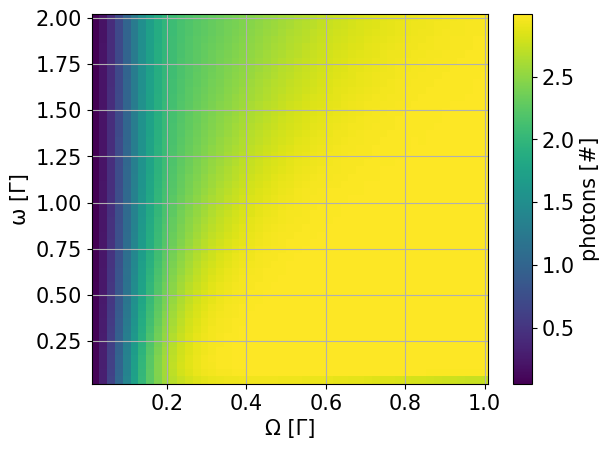

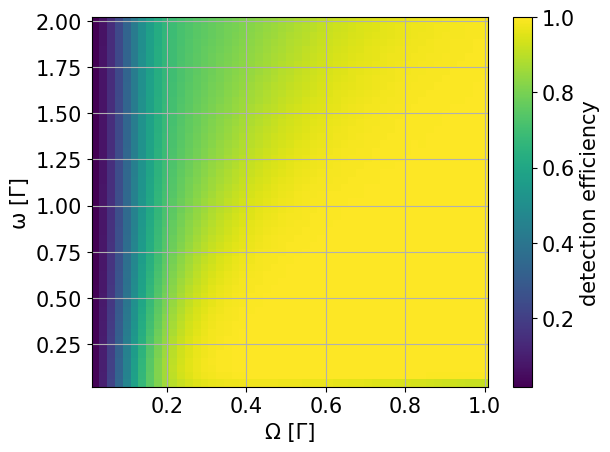

In [40]:
fig, ax = plt.subplots()
pcolor = ax.pcolormesh(
    *(np.asarray(results_F0.scan_values) / hamiltonian.Γ), results_F0.results
)

cbar = fig.colorbar(pcolor)
cbar.ax.set_ylabel("photons [#]")

ax.set_xlabel("Ω [Γ]")
ax.set_ylabel("ω [Γ]")
ax.grid(True)

fig, ax = plt.subplots()
pcolor = ax.pcolormesh(
    *(np.asarray(results_F0.scan_values) / hamiltonian.Γ),
    results_F0.results / results_F0.results.max(),
)

cbar = fig.colorbar(pcolor)
cbar.ax.set_ylabel("detection efficiency")

ax.set_xlabel("Ω [Γ]")
ax.set_ylabel("ω [Γ]")
ax.grid(True)

## Difference in number of photons between F=0 and F=1

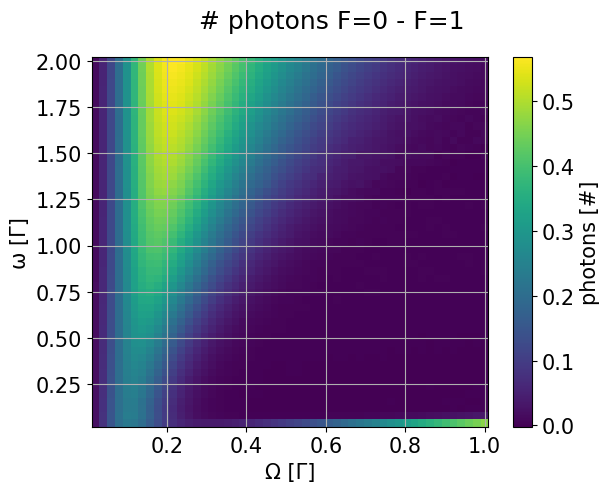

In [41]:
fig, ax = plt.subplots()
pcolor = ax.pcolormesh(
    *(np.asarray(results_F0.scan_values) / hamiltonian.Γ),
    results_F0.results - results_F1.results,
)

cbar = fig.colorbar(pcolor)
cbar.ax.set_ylabel("photons [#]")

fig.suptitle("# photons F=0 - F=1")
ax.set_xlabel("Ω [Γ]")
ax.set_ylabel("ω [Γ]")
ax.grid(True)

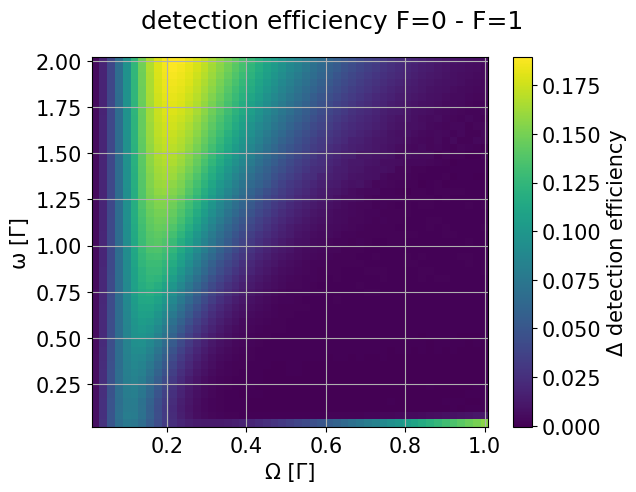

In [42]:
fig, ax = plt.subplots()
pcolor = ax.pcolormesh(
    *(np.asarray(results_F0.scan_values) / hamiltonian.Γ),
    results_F0.results / results_F0.results.max()
    - results_F1.results / results_F1.results.max(),
)

cbar = fig.colorbar(pcolor)
cbar.ax.set_ylabel("Δ detection efficiency")

fig.suptitle("detection efficiency F=0 - F=1")
ax.set_xlabel("Ω [Γ]")
ax.set_ylabel("ω [Γ]")
ax.grid(True)

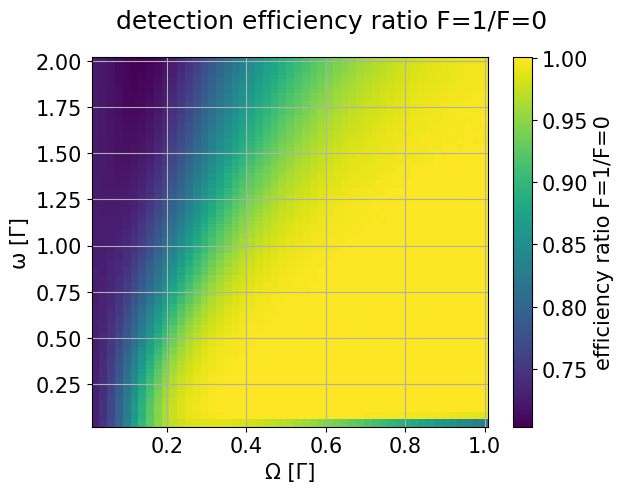

In [43]:
fig, ax = plt.subplots()
pcolor = ax.pcolormesh(
    *(np.asarray(results_F0.scan_values) / hamiltonian.Γ),
    (results_F1.results / results_F1.results.max())
    / (results_F0.results / results_F0.results.max()),
)

cbar = fig.colorbar(pcolor)
cbar.ax.set_ylabel("efficiency ratio F=1/F=0")

fig.suptitle("detection efficiency ratio F=1/F=0")
ax.set_xlabel("Ω [Γ]")
ax.set_ylabel("ω [Γ]")
ax.grid(True)

### Selecting ω = Γ

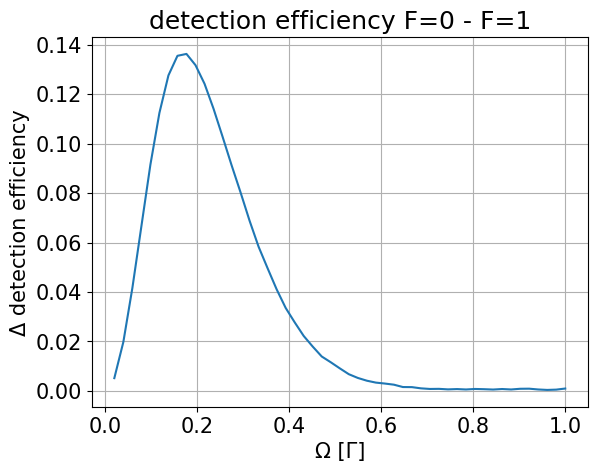

In [44]:
idx = np.argmin((results_F0.scan_values[1] - hamiltonian.Γ) ** 2)

fig, ax = plt.subplots()
ax.plot(
    results_F0.scan_values[0][:, idx] / hamiltonian.Γ,
    (
        results_F0.results / results_F0.results.max()
        - results_F1.results / results_F1.results.max()
    )[:, idx],
)

ax.set_xlabel("Ω [Γ]")
ax.set_ylabel("Δ detection efficiency")
ax.set_title("detection efficiency F=0 - F=1")
ax.grid(True)

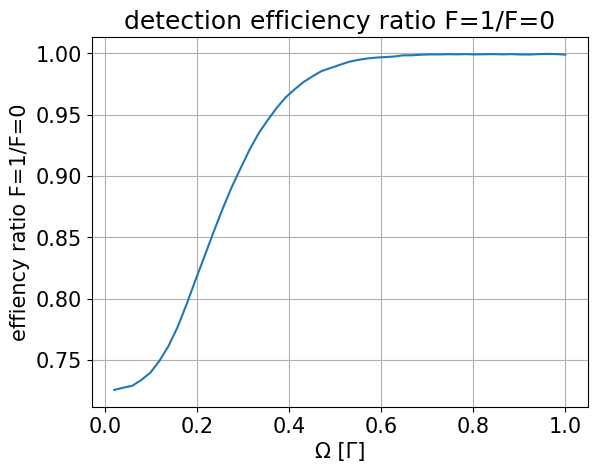

In [45]:
idx = np.argmin((results_F0.scan_values[1] - hamiltonian.Γ) ** 2)

fig, ax = plt.subplots()
ax.plot(
    results_F0.scan_values[0][:, idx] / hamiltonian.Γ,
    (
        (results_F1.results / results_F1.results.max())
        / (results_F0.results / results_F0.results.max())
    )[:, idx],
)

ax.set_xlabel("Ω [Γ]")
ax.set_ylabel("effiency ratio F=1/F=0")
ax.set_title("detection efficiency ratio F=1/F=0")
ax.grid(True)

## Thermal populations

In [46]:
from typing import Sequence, Optional
import numpy.typing as npt
from centrex_tlf.utils.population import thermal_population, J_levels


def generate_thermal_population_states(
    temperature: float,
    QN: Sequence[states.State],
    select: Optional[states.QuantumSelector] = None,
) -> npt.NDArray[np.complex128]:
    levels = len(QN)
    ρ = np.zeros([levels, levels], dtype=complex)

    assert isinstance(QN[0], states.State), "no State objects supplies"

    if select is not None:
        j_levels = np.unique(select.J)
    else:
        j_levels = np.unique(
            [
                qn.largest.J
                for qn in QN
                if qn.largest.electronic_state == states.ElectronicState.X
            ]
        )

    # get the relative thermal population fractions of the ground state
    population = dict(
        [(j, p) for j, p in zip(j_levels, thermal_population(j_levels, temperature))]
    )

    # # get quantum numbers of the ground state
    # quantum_numbers = [
    #     (qn.largest.J, qn.largest.F1, qn.largest.F, qn.largest.mF)
    #     for qn in QN
    #     if qn.largest.electronic_state == states.ElectronicState.X
    # ]

    # assert len(np.unique(quantum_numbers, axis=0)) == len(
    #     quantum_numbers
    # ), "duplicate quantum numbers"

    for idx, qn in enumerate(QN):
        if qn.largest.electronic_state is not states.ElectronicState.X:
            continue
        elif qn.largest.F is None:
            ρ[idx, idx] = population[qn.largest.J]
        else:
            ρ[idx, idx] = population[qn.largest.J] / J_levels(qn.largest.J)

    return ρ

In [47]:
temperature = 6.3

ρ = generate_thermal_population_states(temperature=temperature, QN=obe_system.QN)

In [48]:
ensemble_config = lindblad_julia.OBEEnsembleProblemConfig(
    method="Tsit5()", save_idxs=save_idxs, saveat=1e-6, save_everystep=True
)

problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 5e-3 / odepars.vz))

scan_values = [rabi_rates, polarization_freqs]
parameters = ["Ωl0", "ω0"]

output_func = lindblad_julia.setup_state_integral_calculation_state_idxs(nphotons=True)


ensemble_problem = lindblad_julia.OBEEnsembleProblem(
    problem=problem,
    parameters=parameters,
    scan_values=scan_values,
    output_func=output_func,
)

lindblad_julia.setup_problem_parameter_scan(
    ensemble_problem,
)

lindblad_julia.solve_problem_parameter_scan(ensemble_problem, ensemble_config)

In [49]:
results_thermal = lindblad_julia.get_results_parameter_scan(scan=ensemble_problem)

In [50]:
data["results_thermal"] = results_thermal
with open(path / fname, "wb") as filehandle:
    pickle.dump(data, filehandle)

In [51]:
ρ = generate_thermal_population_states(temperature=temperature, QN=obe_system.QN)

cooling_efficiency = 0.8

br_F0 = 0.337
br_F1 = 0.147

pop_thermal = utils.population.thermal_population(J=np.array([1, 2, 3]), T=temperature)

ρ[0, 0] += pop_thermal.sum() * cooling_efficiency * br_F0 / (br_F0 + br_F1)
ρ[1, 1] += pop_thermal.sum() / 3 * cooling_efficiency * br_F1 / (br_F0 + br_F1)
ρ[2, 2] += pop_thermal.sum() / 3 * cooling_efficiency * br_F1 / (br_F0 + br_F1)
ρ[3, 3] += pop_thermal.sum() / 3 * cooling_efficiency * br_F1 / (br_F0 + br_F1)

In [52]:
expected_gain = (
    np.diag(ρ)[:4].sum()
    / np.diag(
        generate_thermal_population_states(temperature=temperature, QN=obe_system.QN)
    )[:4].sum()
).real

In [53]:
ensemble_config = lindblad_julia.OBEEnsembleProblemConfig(
    method="Tsit5()", save_idxs=save_idxs, saveat=1e-6, save_everystep=True
)

problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 5e-3 / odepars.vz))

scan_values = [rabi_rates, polarization_freqs]
parameters = ["Ωl0", "ω0"]

output_func = lindblad_julia.setup_state_integral_calculation_state_idxs(nphotons=True)


ensemble_problem = lindblad_julia.OBEEnsembleProblem(
    problem=problem,
    parameters=parameters,
    scan_values=scan_values,
    output_func=output_func,
)

lindblad_julia.setup_problem_parameter_scan(
    ensemble_problem,
)

lindblad_julia.solve_problem_parameter_scan(ensemble_problem, ensemble_config)

In [54]:
results_cooling = lindblad_julia.get_results_parameter_scan(scan=ensemble_problem)

In [55]:
data["results_cooling"] = results_cooling
with open(path / fname, "wb") as filehandle:
    pickle.dump(data, filehandle)

### Detected cooling gain

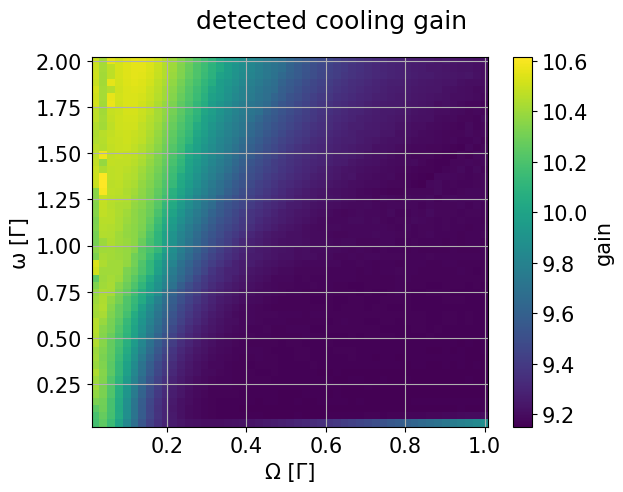

In [56]:
fig, ax = plt.subplots()
pcolor = ax.pcolormesh(
    *(np.asarray(results_cooling.scan_values) / hamiltonian.Γ),
    results_cooling.results / results_thermal.results,
)

cbar = fig.colorbar(pcolor)
cbar.ax.set_ylabel("gain")

fig.suptitle("detected cooling gain")
ax.set_xlabel("Ω [Γ]")
ax.set_ylabel("ω [Γ]")
ax.grid(True)

### Detected cooling gain ratio w.r.t. real gain

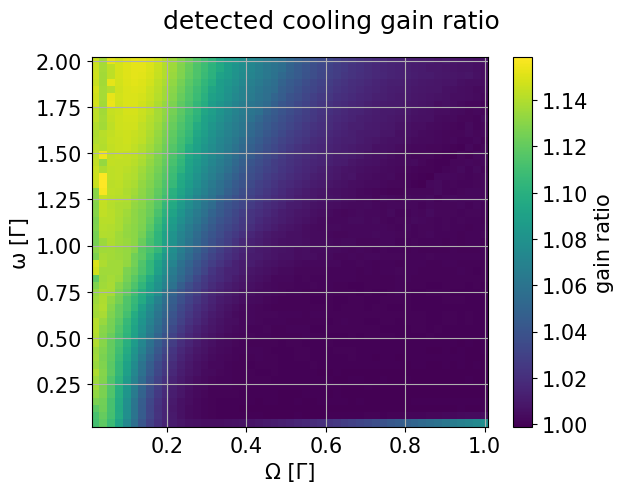

In [57]:
fig, ax = plt.subplots()
pcolor = ax.pcolormesh(
    *(np.asarray(results_cooling.scan_values) / hamiltonian.Γ),
    (results_cooling.results / results_thermal.results) / expected_gain,
)

cbar = fig.colorbar(pcolor)
cbar.ax.set_ylabel("gain ratio")

fig.suptitle("detected cooling gain ratio")
ax.set_xlabel("Ω [Γ]")
ax.set_ylabel("ω [Γ]")
ax.grid(True)

# Full trajectories

In [58]:
v_to_Γ = utils.detuning.velocity_to_detuning(1)
v_to_Γ_μ = 0

odepars = lindblad_julia.odeParameters(
    Ω0="gaussian_2d(y0, z0+vx*t, Ωl0, 0.0, 1e-2, sqrt(σy), sqrt(σz)) * phase_modulation(t, β, ωphase)",
    Ωl0=1 * hamiltonian.Γ,  # Rabi frequency of the laser [rad/s]
    δ0=f"vx*{v_to_Γ}",  # detuning of the laser [rad/s]
    # laser phase modulation
    ωphase=hamiltonian.Γ,  # laser phase modulation frequency [rad/s]
    β=0.0,  # laser phase modulation depth [rad]
    ω0=2 * np.pi * 1.56e6,  # polarization switching frequency [rad/s]
    φ0=0.0,  # polarization switching phase [rad]
    PZ0="resonant_switching(t, ω0, ϕ0)",
    PX0="1-PZ0",
    # molecules
    y0=0.0,
    z0=0.0,  # molecule start z position [m]
    vz=184.0,  # longitudinal molecular velocity [m/s]
    vx=0.0,
    σy=3e-3,
    σz=3e-3,
)

In [59]:
obe_system = lindblad.setup_OBE_system_transitions(
    trans,
    transition_selectors,
    verbose=True,
    qn_compact=True,
    decay_channels=None,
    Jmax_X=3,
)

INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 1/5 -> Generating the reduced Hamiltonian
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 2/5 -> Generating the couplings corresponding to the transitions
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 3/5 -> Generating the symbolic Hamiltonian
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 4/5 -> Generating the collapse matrices
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 5/5 -> Transforming the Hamiltonian and collapse matrices into a symbolic system of equations


In [60]:
obe_system = lindblad_julia.setup_OBE_system_julia(
    obe_system, transition_selectors, odepars
)

## Population in F=1 only

In [61]:
ρ = utils.population.generate_uniform_population_states(
    states.QuantumSelector(J=0, F=1, electronic=states.ElectronicState.X), obe_system.QN
)

rabi_rates = np.abs(
    utils.rabi.power_to_rabi_gaussian_beam(
        np.logspace(-4, -1, 12)[1:],
        obe_system.couplings[0].main_coupling,
        odepars.σy,
        odepars.σz,
    ).real
)

polarization_freqs = np.linspace(0, 2, 12)[1:] * hamiltonian.Γ

vx = np.linspace(-7, 7, 11)
vz = np.linspace(184 - 2.5 * 16, 184 + 2.5 * 16, 11)
y0 = np.linspace(-7e-3, 7e-3, 11)
betas = np.arange(0, 4.1, 1.0)

In [65]:
# only save excited state populations

state_selector = states.QuantumSelector(electronic=states.ElectronicState.B)
indices = state_selector.get_indices(obe_system.QN)
indices = [i.item() for i in indices]

save_idxs = get_diagonal_indices_flattened(len(obe_system.QN), indices, mode="julia")

odepars.ωphase = hamiltonian.Γ
odepars.ω0 = 0.0

In [66]:
stop_function = "vz*t >= 2e-2"

callback = lindblad_julia.setup_discrete_callback_terminate(
    odepars=odepars, stop_expression=stop_function
)

ensemble_config = lindblad_julia.OBEEnsembleProblemConfig(
    method="Tsit5()",
    save_idxs=save_idxs,
    saveat=1e-6,
    save_everystep=True,
    callback=callback,
)


problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 500e-6))


scan_values = [rabi_rates, polarization_freqs, betas, y0, vx, vz]
parameters = ["Ωl0", "ω0", "β", "y0", "vx", "vz"]

output_func = lindblad_julia.setup_state_integral_calculation_state_idxs(nphotons=True)


ensemble_problem = lindblad_julia.OBEEnsembleProblem(
    problem=problem,
    parameters=parameters,
    scan_values=scan_values,
    output_func=output_func,
)

lindblad_julia.setup_problem_parameter_scan(
    ensemble_problem,
)

lindblad_julia.solve_problem_parameter_scan(ensemble_problem, ensemble_config)

In [ ]:
results_F1_trajectories = lindblad_julia.get_results_parameter_scan(
    scan=ensemble_problem
)

In [ ]:
data["results_F1_trajectories"] = results_F1_trajectories
with open(path / fname, "wb") as filehandle:
    pickle.dump(data, filehandle)

In [ ]:
def gaussian(x, μ, σ) -> float:
    return np.exp(-((x - μ) ** 2) / (2 * σ**2))

In [ ]:
vx_conv = gaussian(vx, 0, 2.5)
vx_conv /= vx_conv.sum()
vz_conv = gaussian(vz, 184, 16)
vz_conv /= vz_conv.sum()
y0_conv = gaussian(y0, 0, 3e-3)
y0_conv /= y0_conv.sum()

In [ ]:
r = (((results_F1_trajectories.results @ vz_conv) @ vx_conv) @ y0_conv)[:, :, 0]
sv = (
    results_F1_trajectories.scan_values[0][:, :, 0, 0, 0, 0],
    results_F1_trajectories.scan_values[1][:, :, 0, 0, 0, 0],
)

fig, ax = plt.subplots()
pcolor = ax.pcolormesh(*(np.asarray(sv) / hamiltonian.Γ), r)

cbar = fig.colorbar(pcolor)
cbar.ax.set_ylabel("photons [#]")

ax.set_xlabel("Ω [Γ]")
ax.set_ylabel("ω [Γ]")
ax.grid(True)

fig, ax = plt.subplots()
pcolor = ax.pcolormesh(
    *(np.asarray(sv) / hamiltonian.Γ),
    r / r.max(),
)

cbar = fig.colorbar(pcolor)
cbar.ax.set_ylabel("detection efficiency")

ax.set_xlabel("Ω [Γ]")
ax.set_ylabel("ω [Γ]")
ax.grid(True)

## Population in F=0 only

In [ ]:
ρ = utils.population.generate_uniform_population_states(
    states.QuantumSelector(J=0, F=0, electronic=states.ElectronicState.X), obe_system.QN
)

In [ ]:
ensemble_config = lindblad_julia.OBEEnsembleProblemConfig(
    method="Tsit5()",
    save_idxs=save_idxs,
    saveat=1e-6,
    save_everystep=True,
    callback=callback,
)


problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 500e-6))

output_func = lindblad_julia.setup_state_integral_calculation_state_idxs(nphotons=True)


ensemble_problem = lindblad_julia.OBEEnsembleProblem(
    problem=problem,
    parameters=parameters,
    scan_values=scan_values,
    output_func=output_func,
)

lindblad_julia.setup_problem_parameter_scan(
    ensemble_problem,
)

lindblad_julia.solve_problem_parameter_scan(ensemble_problem, ensemble_config)

In [ ]:
results_F0_trajectories = lindblad_julia.get_results_parameter_scan(
    scan=ensemble_problem
)

In [ ]:
data["results_F0_trajectories"] = results_F0_trajectories
with open(path / fname, "wb") as filehandle:
    pickle.dump(data, filehandle)

In [ ]:
r = (((results_F0_trajectories.results @ vz_conv) @ vx_conv) @ y0_conv)[:, :, 0]
sv = (
    results_F0_trajectories.scan_values[0][:, :, 0, 0, 0, 0],
    results_F0_trajectories.scan_values[1][:, :, 0, 0, 0, 0],
)

fig, ax = plt.subplots()
pcolor = ax.pcolormesh(*(np.asarray(sv) / hamiltonian.Γ), r)

cbar = fig.colorbar(pcolor)
cbar.ax.set_ylabel("photons [#]")

ax.set_xlabel("Ω [Γ]")
ax.set_ylabel("ω [Γ]")
ax.grid(True)

fig, ax = plt.subplots()
pcolor = ax.pcolormesh(
    *(np.asarray(sv) / hamiltonian.Γ),
    r / r.max(),
)

cbar = fig.colorbar(pcolor)
cbar.ax.set_ylabel("detection efficiency")

ax.set_xlabel("Ω [Γ]")
ax.set_ylabel("ω [Γ]")
ax.grid(True)

## Difference in number of photons between F=0 and F=1

In [ ]:
r0 = (((results_F0_trajectories.results @ vz_conv) @ vx_conv) @ y0_conv)[:, :, 0]
r1 = (((results_F1_trajectories.results @ vz_conv) @ vx_conv) @ y0_conv)[:, :, 0]
sv = (
    results_F0_trajectories.scan_values[0][:, :, 0, 0, 0, 0],
    results_F0_trajectories.scan_values[1][:, :, 0, 0, 0, 0],
)

fig, ax = plt.subplots()
pcolor = ax.pcolormesh(
    *(np.asarray(sv) / hamiltonian.Γ),
    r0 - r1,
)

cbar = fig.colorbar(pcolor)
cbar.ax.set_ylabel("photons [#]")

fig.suptitle("# photons F=0 - F=1")
ax.set_xlabel("Ω [Γ]")
ax.set_ylabel("ω [Γ]")
ax.grid(True)

In [ ]:
fig, ax = plt.subplots()
pcolor = ax.pcolormesh(
    *(np.asarray(sv) / hamiltonian.Γ),
    r0 / r0.max() - r1 / r1.max(),
)

cbar = fig.colorbar(pcolor)
cbar.ax.set_ylabel("Δ detection efficiency")

fig.suptitle("detection efficiency F=0 - F=1")
ax.set_xlabel("Ω [Γ]")
ax.set_ylabel("ω [Γ]")
ax.grid(True)

In [ ]:
fig, ax = plt.subplots()
pcolor = ax.pcolormesh(
    *(np.asarray(sv) / hamiltonian.Γ),
    (r1 / r1.max()) / (r0 / r0.max()),
)

cbar = fig.colorbar(pcolor)
cbar.ax.set_ylabel("efficiency ratio F=1/F=0")

fig.suptitle("detection efficiency ratio F=1/F=0")
ax.set_xlabel("Ω [Γ]")
ax.set_ylabel("ω [Γ]")
ax.grid(True)

### Selecting ω = Γ

In [ ]:
idx = np.argmin((sv[1] - hamiltonian.Γ) ** 2)

fig, ax = plt.subplots()
ax.plot(
    sv[0][:, idx] / hamiltonian.Γ,
    (r0 / r0.max() - r1 / r1.max())[:, idx],
)

ax.set_xlabel("Ω [Γ]")
ax.set_ylabel("Δ detection efficiency")
ax.set_title("detection efficiency F=0 - F=1")
ax.grid(True)

In [ ]:
idx = np.argmin((sv[1] - hamiltonian.Γ) ** 2)

fig, ax = plt.subplots()
ax.plot(
    sv[0][:, idx] / hamiltonian.Γ,
    ((r1 / r1.max()) / (r0 / r0.max()))[:, idx],
)

ax.set_xlabel("Ω [Γ]")
ax.set_ylabel("effiency ratio F=1/F=0")
ax.set_title("detection efficiency ratio F=1/F=0")
ax.grid(True)

### Ratio for different β

In [ ]:
for idb in range(results_F0_trajectories.results.shape[2]):
    β = results_F0_trajectories.scan_values[2][0, 0, idb, 0, 0, 0]

    r0 = (((results_F0_trajectories.results @ vz_conv) @ vx_conv) @ y0_conv)[:, :, idb]
    r1 = (((results_F1_trajectories.results @ vz_conv) @ vx_conv) @ y0_conv)[:, :, idb]

    sv = (
        results_F0_trajectories.scan_values[0][:, :, idb, 0, 0, 0],
        results_F0_trajectories.scan_values[1][:, :, idb, 0, 0, 0],
    )

    fig, ax = plt.subplots()
    pcolor = ax.pcolormesh(
        *(np.asarray(sv) / hamiltonian.Γ),
        (r1 / r1.max()) / (r0 / r0.max()),
        vmin=0.7,
        vmax=1.0,
    )

    cbar = fig.colorbar(pcolor)
    cbar.ax.set_ylabel("efficiency ratio F=1/F=0")

    fig.suptitle(f"detection efficiency ratio F=1/F=0; {β=}")
    ax.set_xlabel("Ω [Γ]")
    ax.set_ylabel("ω [Γ]")
    ax.grid(True)

## Thermal Population

In [ ]:
temperature = 6.3

ρ = generate_thermal_population_states(temperature=temperature, QN=obe_system.QN)

In [ ]:
ensemble_config = lindblad_julia.OBEEnsembleProblemConfig(
    method="Tsit5()",
    save_idxs=save_idxs,
    saveat=1e-6,
    save_everystep=True,
    callback=callback,
)


problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 500e-6))

output_func = lindblad_julia.setup_state_integral_calculation_state_idxs(nphotons=True)


ensemble_problem = lindblad_julia.OBEEnsembleProblem(
    problem=problem,
    parameters=parameters,
    scan_values=scan_values,
    output_func=output_func,
)

lindblad_julia.setup_problem_parameter_scan(
    ensemble_problem,
)

lindblad_julia.solve_problem_parameter_scan(ensemble_problem, ensemble_config)

In [ ]:
results_thermal_trajectories = lindblad_julia.get_results_parameter_scan(
    scan=ensemble_problem
)

In [ ]:
data["results_thermal_trajectories"] = results_thermal_trajectories
with open(path / fname, "wb") as filehandle:
    pickle.dump(data, filehandle)

In [ ]:
ρ = generate_thermal_population_states(temperature=temperature, QN=obe_system.QN)

cooling_efficiency = 0.8

br_F0 = 0.337
br_F1 = 0.147

pop_thermal = utils.population.thermal_population(J=np.array([1, 2, 3]), T=temperature)

ρ[0, 0] += pop_thermal.sum() * cooling_efficiency * br_F0 / (br_F0 + br_F1)
ρ[1, 1] += pop_thermal.sum() / 3 * cooling_efficiency * br_F1 / (br_F0 + br_F1)
ρ[2, 2] += pop_thermal.sum() / 3 * cooling_efficiency * br_F1 / (br_F0 + br_F1)
ρ[3, 3] += pop_thermal.sum() / 3 * cooling_efficiency * br_F1 / (br_F0 + br_F1)

In [ ]:
expected_gain = (
    np.diag(ρ)[:4].sum()
    / np.diag(
        generate_thermal_population_states(temperature=temperature, QN=obe_system.QN)
    )[:4].sum()
).real

In [ ]:
ensemble_config = lindblad_julia.OBEEnsembleProblemConfig(
    method="Tsit5()",
    save_idxs=save_idxs,
    saveat=1e-6,
    save_everystep=True,
    callback=callback,
)


problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 500e-6))

output_func = lindblad_julia.setup_state_integral_calculation_state_idxs(nphotons=True)


ensemble_problem = lindblad_julia.OBEEnsembleProblem(
    problem=problem,
    parameters=parameters,
    scan_values=scan_values,
    output_func=output_func,
)

lindblad_julia.setup_problem_parameter_scan(
    ensemble_problem,
)

lindblad_julia.solve_problem_parameter_scan(ensemble_problem, ensemble_config)

In [ ]:
results_cooling_trajectories = lindblad_julia.get_results_parameter_scan(
    scan=ensemble_problem
)

In [ ]:
data["results_cooling_trajectories"] = results_cooling_trajectories
with open(path / fname, "wb") as filehandle:
    pickle.dump(data, filehandle)

### Detected cooling gain

In [ ]:
idb = 0
β = results_thermal_trajectories.scan_values[2][0, 0, idb, 0, 0, 0]

rt = (((results_thermal_trajectories.results @ vz_conv) @ vx_conv) @ y0_conv)[:, :, idb]
rc = (((results_cooling_trajectories.results @ vz_conv) @ vx_conv) @ y0_conv)[:, :, idb]

sv = (
    results_thermal_trajectories.scan_values[0][:, :, idb, 0, 0, 0],
    results_thermal_trajectories.scan_values[1][:, :, idb, 0, 0, 0],
)

fig, ax = plt.subplots()
pcolor = ax.pcolormesh(
    *(np.asarray(sv) / hamiltonian.Γ),
    rc / rt,
)

cbar = fig.colorbar(pcolor)
cbar.ax.set_ylabel("gain")

fig.suptitle("detected cooling gain")
ax.set_xlabel("Ω [Γ]")
ax.set_ylabel("ω [Γ]")
ax.grid(True)

### Detected cooling gain ratio w.r.t. real gain

In [ ]:
for idb in range(results_F0_trajectories.results.shape[2]):
    β = results_F0_trajectories.scan_values[2][0, 0, idb, 0, 0, 0]
    β = results_thermal_trajectories.scan_values[2][0, 0, idb, 0, 0, 0]

    rt = (((results_thermal_trajectories.results @ vz_conv) @ vx_conv) @ y0_conv)[
        :, :, idb
    ]
    rc = (((results_cooling_trajectories.results @ vz_conv) @ vx_conv) @ y0_conv)[
        :, :, idb
    ]

    sv = (
        results_thermal_trajectories.scan_values[0][:, :, idb, 0, 0, 0],
        results_thermal_trajectories.scan_values[1][:, :, idb, 0, 0, 0],
    )

    fig, ax = plt.subplots()
    pcolor = ax.pcolormesh(
        *(np.asarray(sv) / hamiltonian.Γ),
        (rc / rt) / expected_gain,
    )

    cbar = fig.colorbar(pcolor)
    cbar.ax.set_ylabel("gain ratio")

    fig.suptitle(f"detected cooling gain ratio {β=}")
    ax.set_xlabel("Ω [Γ]")
    ax.set_ylabel("ω [Γ]")
    ax.grid(True)

### Slice at ω0 = Γ

In [ ]:
rabi_estimate = np.abs(
    utils.rabi.power_to_rabi_gaussian_beam(
        25e-3,
        obe_system.couplings[0].main_coupling,
        odepars.σy,
        odepars.σz,
    ).real
)

In [ ]:
fig, ax = plt.subplots()

ax.axvline(rabi_estimate / hamiltonian.Γ, lw=2, color="k")

for idb in range(results_F0_trajectories.results.shape[2]):
    β = results_thermal_trajectories.scan_values[2][0, 0, idb, 0, 0, 0]

    rt = (((results_thermal_trajectories.results @ vz_conv) @ vx_conv) @ y0_conv)[
        :, :, idb
    ]
    rc = (((results_cooling_trajectories.results @ vz_conv) @ vx_conv) @ y0_conv)[
        :, :, idb
    ]

    sv = (
        results_thermal_trajectories.scan_values[0][:, :, idb, 0, 0, 0],
        results_thermal_trajectories.scan_values[1][:, :, idb, 0, 0, 0],
    )

    idw = np.argmin(((sv[1] / hamiltonian.Γ) - 1) ** 2)
    x = sv[1][idw] / hamiltonian.Γ

    ax.plot(x, ((rc / rt) / expected_gain)[:, idw], lw=2, label=f"{β=}")


fig.suptitle("detected cooling gain ratio")
ax.set_xlabel("Ω [Γ]")
ax.set_ylabel("gain ratio")
ax.legend()
ax.grid(True)

In [ ]:
plt.plot(y0, y0_conv)